# Загрузка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression, Lasso, Ridge, LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tqdm import tqdm

C:\Users\tibec\AppData\Local\Temp\ipykernel_10492\3252491036.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
df = pd.read_csv('data_prepared.csv')
df.sort_values(by='date', inplace=True)
df.head()

,date,water_temp,cloudiness_0,precipitation_0,temp_0,wind_dir_0,wind_speed_0,wind_dir_x_0,wind_dir_y_0,pressure_0,...,temp_24,wind_dir_24,wind_speed_24,wind_dir_x_24,wind_dir_y_24,pressure_24,month,day,day_length,solar_elevation
0,2011-01-01,0.3,пасмурно,без осадков,-1.0,З,3.0,-5.510911e-16,-3.000000e+00,754.0,...,-3.0,ЮВ,2.0,-1.414214,1.414214e+00,754.0,1,1,6.168333,7.600029
1,2011-01-02,0.3,малооблачно,слабые осадки,-3.0,ЮВ,2.0,-1.414214e+00,1.414214e+00,754.0,...,-4.0,ЮВ,1.0,-0.707107,7.071068e-01,754.0,1,2,6.199444,7.684113
2,2011-01-03,0.2,пасмурно,без осадков,-4.0,ЮВ,1.0,-7.071068e-01,7.071068e-01,754.0,...,-5.0,ЮЮЗ,2.0,-1.847759,-7.653669e-01,753.0,1,3,6.233333,7.775738
3,2011-01-04,2.3,ясно,без осадков,-5.0,ЮЮЗ,2.0,-1.847759e+00,-7.653669e-01,753.0,...,-5.0,Ю,2.0,-2.000000,2.449294e-16,753.0,1,4,6.269722,7.874868
4,2011-01-05,2.1,пасмурно,без осадков,-5.0,Ю,2.0,-2.000000e+00,2.449294e-16,753.0,...,-5.0,ЮЗ,1.0,-0.707107,-7.071068e-01,755.0,1,5,6.308333,7.981454


In [3]:
df.drop(columns=[col for col in df.columns if col.endswith('_24')], inplace=True)

In [4]:
X, y = df.drop(['date', 'water_temp'], axis=1), df['water_temp']
categorical = [col for col in X.columns if X[col].dtype == 'O']
X = pd.get_dummies(X, columns=['month', 'day', *categorical], drop_first=True)

In [5]:
def generate_X(X, ndays=7):
    for i in tqdm(range(len(X) - ndays), desc='Generating X', leave=False):
        yield pd.concat([X.iloc[i:i+ndays], y.iloc[i:i+ndays].T], axis=1).melt().value.T
    
def generate_y(y, ndays=7):
    for i in tqdm(range(len(y) - ndays), desc='Generating y', leave=False):
        yield y.iloc[i+ndays]
    

def gen_data(X, y, ndays=7):
    # добавить проверку что дни не подряд
    
    return pd.concat(generate_X(X, ndays), ignore_index=True, axis=1).T, pd.Series(list(generate_y(y, ndays)))

In [9]:
X1, y1 = gen_data(X, y, 1)
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=42)

In [10]:
X1.shape, y1.shape

((4379, 304), (4379,))

In [11]:
lr = Lasso().fit(X1_train, y1_train)
y1_pred = lr.predict(X1_test)
print(f'MAE: {mean_absolute_error(y1_test, y1_pred)}, MSE: {mean_squared_error(y1_test, y1_pred)}, R2: {r2_score(y1_test, y1_pred)}')

MAE: 0.508579199890564, MSE: 0.7891774001455361, R2: 0.9803360262274997


In [ ]:
days_range = range(1, 10)
err = []

for _ndays in tqdm(days_range, desc='Days range'):
    X1, y1 = gen_data(X, y, _ndays)
    err.append(-cross_val_score(RandomForestRegressor(), X1, y1, cv=3, scoring='neg_mean_absolute_error').mean())

plt.plot(days_range, err)
plt.xlabel('Number of days')
plt.ylabel('MAE')
plt.show()

# Тест моделей

In [9]:
X1, y1 = gen_data(X, y, 5)
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2)

In [205]:
params = {'n_estimators': [100, 200, 300, 400, 500],
          'max_depth': [3, 5, 7, 9, 11],
          'min_samples_leaf': [1, 2, 3, 4, 5],
          'max_features': [0.5, 0.6, 0.7, 0.8, 0.9]}

rf = RandomForestRegressor()
random_search = RandomizedSearchCV(rf, param_distributions=params, n_iter=100, cv=4, n_jobs=-1, verbose=3)
random_search.fit(X1_train, y1_train)
print(random_search.best_params_)
print(random_search.best_score_)
mean_absolute_error(y1_test, random_search.predict(X1_test))

Fitting 4 folds for each of 100 candidates, totalling 400 fits
{'n_estimators': 300, 'min_samples_leaf': 4, 'max_features': 0.8, 'max_depth': 7}
0.9872470163367867


0.5031573535569034

In [11]:
model = Lasso(alpha=0.1).fit(X1_train, y1_train)
y1_pred = model.predict(X1_test)
print(f'MAE: {mean_absolute_error(y1_test, y1_pred)}, MSE: {mean_squared_error(y1_test, y1_pred)}, R2: {r2_score(y1_test, y1_pred)}')

MAE: 0.45066482507875466, MSE: 0.6235908517996926, R2: 0.9852982821901276


Days range:   0%|          | 0/19 [00:00<?, ?it/s]

Days range: 100%|██████████| 19/19 [10:10<00:00, 32.12s/it]


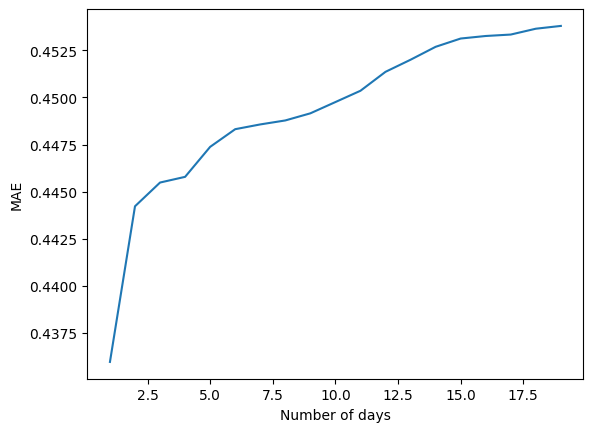

In [10]:
days_range = range(1, 20)
err = []

for _ndays in tqdm(days_range, desc='Days range'):
    X1, y1 = gen_data(X, y, _ndays)
    err.append(-cross_val_score(Lasso(alpha=0.1), X1, y1,
               cv=3, scoring='neg_mean_absolute_error').mean())

plt.plot(days_range, err)
plt.xlabel('Number of days')
plt.ylabel('MAE')
plt.show()

In [6]:
X1, y1 = gen_data(X, y, 1)
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2)

In [7]:
print(f'MAE: {-cross_val_score(Lasso(alpha=0.05), X1, y1, cv=3, scoring="neg_mean_absolute_error").mean()}')
print(f'MSE: {-cross_val_score(Lasso(alpha=0.05), X1, y1, cv=3, scoring="neg_mean_squared_error").mean()}')
print(f'R2: {cross_val_score(Lasso(alpha=0.05), X1, y1, cv=3, scoring="r2").mean()}')

MAE: 0.4351974388845581
MSE: 0.6234972548522687
R2: 0.9852309759742278


In [8]:
import pickle

model = Lasso(alpha=0.05).fit(X1, y1)

# save the classifier
with open('model.pkl', 'wb') as fid:
    pickle.dump(model, fid)

# load it again
with open('model.pkl', 'rb') as fid:
    model_loaded = pickle.load(fid)